# Food Safety Computer Vision Project - Glove Model Training

The basic idea here is to find if a baker in a commercial kitchen is wearing PPE.

We take two pre-trained YOLO models which detect the head and hands. Then we train another YOLO model on the kitchen hygiene dataset and hairnet dataset to learn to detect gloves and hairnets.

Here are the steps we followed to make this project:

1. Got a YOLO model to detect a person's head from Head Detector using [Yolov8](https://github.com/AbelKidaneHaile/Reports)
2. Trained a YOLOv8 model to detect the presence or absence of hairnets. This model can even differentiate between hairnets and hats. The code for this model is [here](https://www.kaggle.com/code/laibafaisal1310/hairnet-v1-0/notebook).
3. Trained a YOLOv8 model to detect gloves. We used the Kitchen hygiene dataset for this.
4. As per the professor's recommendation, we used 100 Days of Hands. We tried to create our own model here, however we found another model that already exists.

# Setting up imports and Google drive and

In [1]:
import os
import zipfile
import requests
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initially, we used the kaggle_hairnet dataset to train our YOLO model, but this model could not differentiate between a bald head and hairnet, so we trained another model, which can be found in hairnet_training.ipynb

In [3]:
import os
from google.colab import files

# Ensure the .kaggle directory exists
!mkdir -p ~/.kaggle

# Upload your Kaggle API key (get it from your Kaggle account settings)
print("Please upload your kaggle.json file:")
files.upload()

# Move the uploaded kaggle.json to the correct directory and set permissions
# Assuming the uploaded file is named 'kaggle.json'
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key setup complete!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API key setup complete!


In [4]:
!pip install -q kaggle

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00


# Getting the dataset

First, let's get the kitchen hygiene dataset and extract it into folders.

In [6]:
!wget -O kitchen_hygiene_gear.zip "https://zenodo.org/records/16329852/files/kitchen%20hygiene%20gear.zip?download=1"

--2025-12-17 17:17:36--  https://zenodo.org/records/16329852/files/kitchen%20hygiene%20gear.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1944884945 (1.8G) [application/octet-stream]
Saving to: ‘kitchen_hygiene_gear.zip’

kitchen_hygiene_gea 100%[===================>]   1.81G  12.2MB/s    in 8m 28s  

2025-12-17 17:26:05 (3.65 MB/s) - ‘kitchen_hygiene_gear.zip’ saved [1944884945/1944884945]



In [7]:
import zipfile
extract_dir = "kitchen_hygiene_gear"
with zipfile.ZipFile("kitchen_hygiene_gear.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [8]:
extract_dir = "kitchen_hygiene_gear/kitchen hygiene gear/train"
images_dir = extract_dir + "/images"
labels_dir = extract_dir + "/labels"

In [9]:
# We create a yaml file here to tell the YOLO model to only care about the glove label
# The kitchen hygiene dataset has many labels - like glove/no glove, hairnet/no hairnet etc
yaml_text = '''
train: kitchen_hygiene_gear/kitchen hygiene gear/train/images
val: kitchen_hygiene_gear/kitchen hygiene gear/valid/images
names:
  - glove
'''
with open('glove.yaml', 'w') as f:
    f.write(yaml_text)

In [10]:
import os
os.makedirs('/content/drive/MyDrive/ComputerVision/glove', exist_ok=True)
if os.path.islink('/content/runs'):
    os.unlink('/content/runs')
os.symlink('/content/drive/MyDrive/ComputerVision/glove', '/content/runs')


# Train the YOLO model

Now, we will train our model with the .yaml file we just created

In [13]:
from ultralytics import YOLO

# Load the YOLOv8n pretrained weights
model = YOLO('yolov8n.pt')

# Train
results = model.train(
    data='glove.yaml',
    epochs=20,
    imgsz=640,
    batch=8
)

Streaming output truncated to the last 5000 lines.
train: /content/kitchen_hygiene_gear/kitchen hygiene gear/train/images/mask_data_102_mp4-37_jpg.rf.983894713af469c87ec6c3778952e655.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/kitchen_hygiene_gear/kitchen hygiene gear/train/images/mask_data_102_mp4-37_jpg.rf.d73a1461415e4d016acc2ab339973646.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/kitchen_hygiene_gear/kitchen hygiene gear/train/images/mask_data_102_mp4-39_jpg.rf.143a056c5101bf424553a7b3826803a7.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/kitchen_hygiene_gear/kitchen hygiene gear/train/images/mask_data_102_mp4-39_jpg.rf.606c190e6b14643a439a53ea20086050.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 1. Possible cl

Here, we perform inference on a test image, which was uploaded in the colab notebook.


image 1/1 /content/drive/MyDrive/ComputerVision/glove-hairnet.jpg: 448x640 1 glove, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


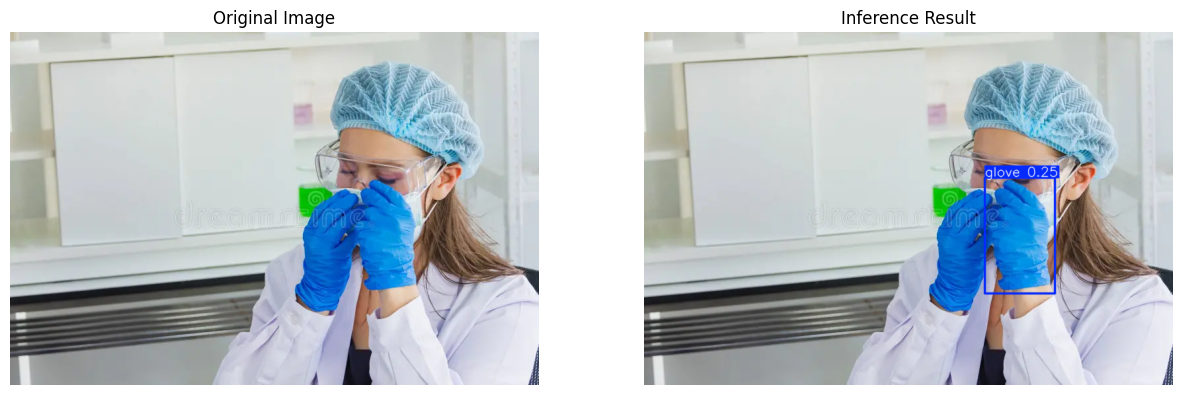

In [21]:
# 1. Load the Model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# 2. Define image path
img_path = '/content/drive/MyDrive/ComputerVision/glove-hairnet.jpg'

# 3. Run Inference
results = model(img_path)

# 4. Display Images Side-by-Side (or one after another)
# Open original image using PIL
original_img = Image.open(img_path)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Show Original
axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show Result
# results[0].plot() returns a numpy array of the annotated image in BGR, needs conversion to RGB
res_plotted = results[0].plot()
axes[1].imshow(res_plotted[..., ::-1]) # Convert BGR to RGB for matplotlib
axes[1].set_title("Inference Result")
axes[1].axis('off')

plt.show()